In [110]:
!nvidia-smi -L


GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-2ce5d4ad-7fb5-c92e-3f65-bd6c7f5c4a0e)


# Install Library

In [111]:
!pip install wandb torchsummaryX


In [112]:
%matplotlib inline
import pandas
import sklearn
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import re
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from PIL import Image
import os
import glob

from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, SGD
from IPython.display import display
from torchsummaryX import summary
from torch.optim import lr_scheduler

from collections import defaultdict, Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.exceptions import UndefinedMetricWarning

# from transformers import get_linear_schedule_with_warmup

from torch.nn.utils.rnn import pad_sequence, pad_packed_sequence, pack_padded_sequence
from torch.nn import Embedding, Dropout, GRU, LSTM, Linear, CrossEntropyLoss 


In [113]:
device = torch.device("cuda:0")
print(f"Using {device} device")

Using cuda:0 device


In [114]:
classes = ['canal', 'electric', 'flooding', 'light', 'road', 'sanitary', 'sewer', 'sidewalk', 'stray', 'traffic']
classes_idx = list(range(len(classes)))
classes_idx = dict(zip(classes, classes_idx))
classes_idx

{'canal': 0,
 'electric': 1,
 'flooding': 2,
 'light': 3,
 'road': 4,
 'sanitary': 5,
 'sewer': 6,
 'sidewalk': 7,
 'stray': 8,
 'traffic': 9}

In [116]:
import albumentations as A
from albumentations.pytorch import ToTensorV2


transform_train = transforms.Compose(
    [transforms.Resize((230,230)),
        transforms.RandomRotation(30,),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4303, 0.4301, 0.4139], std=[0.2186, 0.2140, 0.2205]) #nomalize imagenet pretrain
    ])

transform = transforms.Compose(
    [transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4303, 0.4301, 0.4139], std=[0.2186, 0.2140, 0.2205])
    ])


In [117]:
import os
import pandas as pd
import argparse

path = '/kaggle/input/cleaned-train4/train'
def gen_filename():
    classes = os.listdir(path)
    print(classes)
    d = {}
    for c in classes:
        if c == '.DS_Store':
            continue
#         print(c)
        images = os.listdir(path+'/' + c)
#         count = 0
        for image in images:
            if image == '.DS_Store': continue
#             if count > 600: break
            d[image] = c
#             count+=1

    df = pd.DataFrame(d.items(), columns=['filename', 'class'])
    df.to_csv('filenames.csv', index=False)


gen_filename()


['flooding', 'road', 'sidewalk', 'electric', 'canal', 'traffic', 'sewer', 'sanitary', 'stray', 'light']


In [118]:
df = pd.read_csv('/kaggle/working/filenames.csv')
df

,filename,class
0,train_flooding_img_130.jpg,flooding
1,train_flooding_img_839.jpg,flooding
2,train_flooding_img_1969.jpg,flooding
3,train_flooding_img_1381.jpg,flooding
4,train_flooding_img_1402.jpg,flooding
...,...,...
7143,train_light_img_729.jpg,light
7144,train_light_img_601.jpg,light
7145,train_light_img_645.jpg,light
7146,train_light_img_753.jpg,light


In [119]:
df['class'].value_counts()

road        1331
flooding    1237
electric     941
light        790
sidewalk     746
traffic      465
canal        436
sewer        429
sanitary     427
stray        346
Name: class, dtype: int64

In [121]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(df, test_size=0.2, stratify=df['class'], random_state=2022)
test_data, val_data = train_test_split(test_data, test_size=0.5, stratify=test_data['class'], random_state=2022)

In [122]:
class TraffyFondueDataset(Dataset):
    
    def __init__(self, 
                 data, 
                 transforms=None):
        
        super().__init__()
        label_image = classes
        self.input_dataset = list()
        for i in range(len(data)):
            img_dir = path
            
            input = [os.path.join(img_dir, data.iloc[i,1].strip(), data.iloc[i,0].strip()), classes_idx[data.iloc[i,1].strip()]] # [image_path, label_num]
            self.input_dataset.append(input)
        
        self.transforms = transforms

    def __len__(self):
        return len(self.input_dataset)

    def __getitem__(self, idx): 
        img = Image.open(self.input_dataset[idx][0]).convert('RGB')
        x = self.transforms(img)
        y = self.input_dataset[idx][1]
        return x,y

trainset = TraffyFondueDataset(train_data, transform_train)
valset = TraffyFondueDataset(val_data,transform)
testset = TraffyFondueDataset(test_data,transform)

allset = TraffyFondueDataset(df, transform_train)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
# valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True)
# testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)


In [123]:
folder_name = []
num_images = []
for subfolder_name in os.listdir(path):
    # if subfolder_name in ['training', 'testing', 'validating']: continue
    subfolder_path = os.path.join(path, subfolder_name)
    if os.path.isdir(subfolder_path):
        num_image = len([file for file in os.listdir(subfolder_path) if file.endswith(('.jpg', '.png'))])
        num_images.append(num_image)
        folder_name.append(subfolder_name)
        print("Subfolder '{}' contains \t{} images".format(subfolder_name, num_image))



Subfolder 'flooding' contains 	1237 images
Subfolder 'road' contains 	1331 images
Subfolder 'sidewalk' contains 	746 images
Subfolder 'electric' contains 	941 images
Subfolder 'canal' contains 	436 images
Subfolder 'traffic' contains 	465 images
Subfolder 'sewer' contains 	429 images
Subfolder 'sanitary' contains 	427 images
Subfolder 'stray' contains 	346 images
Subfolder 'light' contains 	790 images


In [124]:
unique_values, counts = np.unique(df['class'], return_counts=True)
counts_lis = []
label_lis = []
for val, count in zip(unique_values, counts):
    counts_lis.append(count)
    label_lis.append(val)
counts_lis = np.array(counts_lis)
# indices = np.where(counts_lis < 20)[0]

In [125]:
counts_lis

array([ 436,  941, 1237,  790, 1331,  427,  429,  746,  346,  465])

In [126]:
def get_weights_inverse_num_of_samples (no_of_classes, samples_per_cls, power = 1) :
    weights_for_samples = 1.0 / np.array (np.power (samples_per_cls, power))
    weights_for_samples = weights_for_samples / np.sum(weights_for_samples) * no_of_classes
    return weights_for_samples

In [127]:
num_classes=10
class_weights = get_weights_inverse_num_of_samples(10,  counts_lis)
class_weights.shape

(10,)

In [128]:
summary_stats = {
    'mean': np.mean(class_weights, axis=0),
    'std': np.std(class_weights, axis=0),
    'min': np.min(class_weights, axis=0),
    'max': np.max(class_weights, axis=0),
}
summary_stats

{'mean': 1.0,
 'std': 0.41818872697525933,
 'min': 0.43590013807099337,
 'max': 1.6768297218858152}

In [129]:
class_weights = torch.Tensor(class_weights).to(device)


In [130]:
BATCH_SIZE = 32
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True)
allloader = torch.utils.data.DataLoader(allset, batch_size=BATCH_SIZE, shuffle=True)

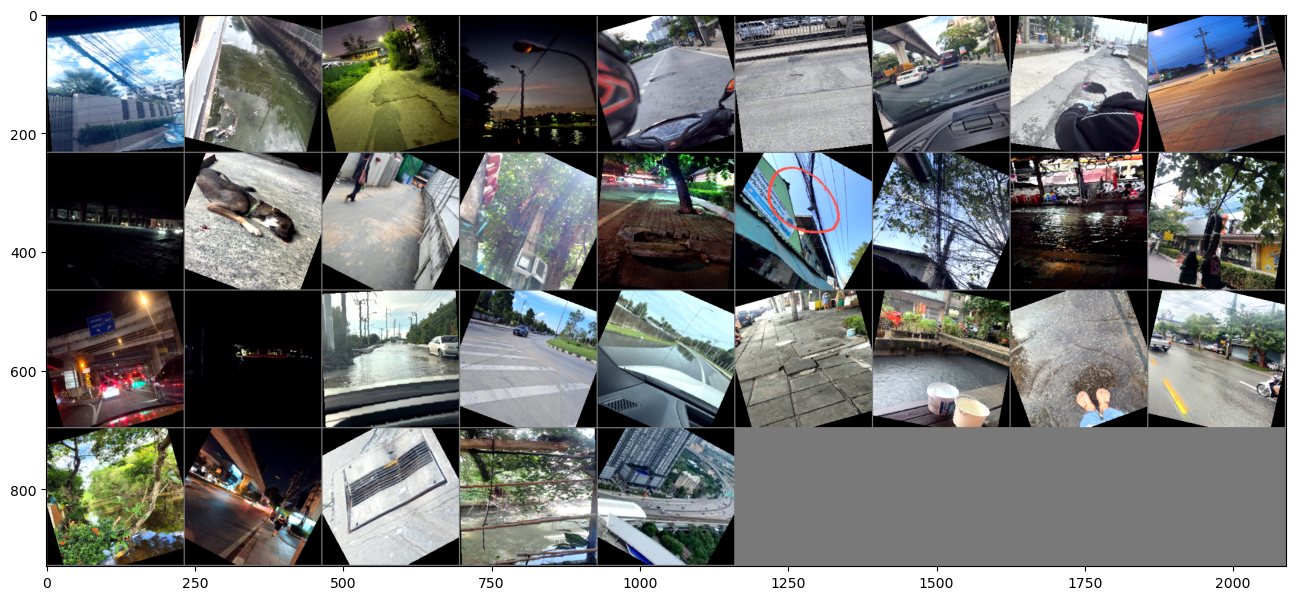

In [131]:
# functions to show an image
def imshow(img):
    img = img*torch.tensor([0.267, 0.256, 0.276]).mean() + torch.tensor([0.507, 0.487, 0.441]).mean()     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(16,16))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(allloader)
images, labels = next(dataiter)

# show images
nrow = 9
imshow(torchvision.utils.make_grid(images, nrow = nrow))

In [132]:
# print labels
for i in range(BATCH_SIZE//nrow + 1 if BATCH_SIZE % nrow else 0):
  print(' '.join(f'{labels[i*nrow+j]:<3}' for j in range(min(BATCH_SIZE - i*nrow, nrow))))

1   0   4   3   4   4   4   4   4  
4   8   4   1   7   1   1   2   1  
9   3   2   4   2   6   0   2   2  
2   3   6   0   4  


In [133]:
#pretrain_weight = torchvision.models.EfficientNet_V2_S_Weights.IMAGENET1K_V1
#net = torchvision.models.efficientnet_v2_s(weights = pretrain_weight)
#net.classifier[1] = nn.Linear(1280, 102)
#net = net.to(device)
#mobile_net 
num_classes = 10
model_ft = torchvision.models.efficientnet_b3(weights=True)
# model_ft = torchvision.models.resnet50(pretrained=True).to(device)
# model_ft = torchvision.models.vgg16(pretrained=True).to(device)

# Freeze all the pre-trained layers
# for param in model_ft.parameters():
#     param.requires_grad = False
    
model_ft.classifier[-1] = nn.Sequential(
#     nn.Linear(in_features=model_ft.classifier[-1].in_features, out_features=model_ft.classifier[-1].in_features),
#     nn.LSTM(model_ft.classifier[-1].in_features, model_ft.classifier[-1].in_features, bidirectional = False, num_layers=1, batch_first=True),
    nn.Linear(in_features=model_ft.classifier[-1].in_features, out_features=num_classes),
    nn.Softmax(dim=1)
        )

model = model_ft.to(device)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [134]:
# all augmented dataV2 except vertical flip, random crop, and colorjitter, seed = 2022
# BATCH_SIZE = 32
NUM_EPOCHS = 20
criterion = nn.CrossEntropyLoss(weight=class_weights)
# criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
# scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda epoch: epoch / NUM_EPOCHS)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)

# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5)

In [135]:
summary(model, torch.zeros((128, 3, 224, 224), dtype = torch.float).to(device))


/opt/conda/lib/python3.7/site-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum = df.sum()


                                                         Kernel Shape  \
Layer                                                                   
0_features.0.Conv2d_0                                   [3, 40, 3, 3]   
1_features.0.BatchNorm2d_1                                       [40]   
2_features.0.SiLU_2                                                 -   
3_features.1.0.block.0.Conv2d_0                         [1, 40, 3, 3]   
4_features.1.0.block.0.BatchNorm2d_1                             [40]   
5_features.1.0.block.0.SiLU_2                                       -   
6_features.1.0.block.1.AdaptiveAvgPool2d_avgpool                    -   
7_features.1.0.block.1.Conv2d_fc1                      [40, 10, 1, 1]   
8_features.1.0.block.1.SiLU_activation                              -   
9_features.1.0.block.1.Conv2d_fc2                      [10, 40, 1, 1]   
10_features.1.0.block.1.Sigmoid_scale_activation                    -   
11_features.1.0.block.2.Conv2d_0                   

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_features.0.Conv2d_0,"[3, 40, 3, 3]","[128, 40, 112, 112]",1080.0,13547520.0
1_features.0.BatchNorm2d_1,[40],"[128, 40, 112, 112]",80.0,40.0
2_features.0.SiLU_2,-,"[128, 40, 112, 112]",NaN,NaN
3_features.1.0.block.0.Conv2d_0,"[1, 40, 3, 3]","[128, 40, 112, 112]",360.0,4515840.0
4_features.1.0.block.0.BatchNorm2d_1,[40],"[128, 40, 112, 112]",80.0,40.0
...,...,...,...,...
356_features.8.SiLU_2,-,"[128, 1536, 7, 7]",NaN,NaN
357_avgpool,-,"[128, 1536, 1, 1]",NaN,NaN
358_classifier.Dropout_0,-,"[128, 1536]",NaN,NaN


In [136]:
from sklearn.metrics import classification_report
from tqdm import tqdm



history_train = {'loss':np.zeros(NUM_EPOCHS), 'acc':np.zeros(NUM_EPOCHS), 'macro_f1-score':np.zeros(NUM_EPOCHS)}
history_val = {'loss':np.zeros(NUM_EPOCHS), 'acc':np.zeros(NUM_EPOCHS), 'macro_f1-score':np.zeros(NUM_EPOCHS)}
min_val_loss = 1e10
best_f1 = -1
PATH = './best_model.pth'
PATH_F1 = './best_model_f1.pth'

for epoch in range(NUM_EPOCHS):  
    
    print(f'epoch {epoch + 1} \nTraining ...')
    model.train()
    y_predict = list()
    y_labels = list()
    training_loss = 0.0
    n = 0
    with torch.set_grad_enabled(True):
        for inputs, labels in tqdm(trainloader):
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            training_loss += loss.item()
            n+=1

            y_labels += list(labels.cpu().numpy())
            y_predict += list(outputs.argmax(dim=1).cpu().numpy())
    scheduler.step()

    report = classification_report(y_labels, y_predict, digits = 4, output_dict = True)
    acc = report["accuracy"]
    f1 = report["macro avg"]["f1-score"]
    support = report["macro avg"]["support"]
    training_loss /= n
    print(f"training loss: {training_loss:.4}, acc: {acc*100:.4}%,  Macro f1-score: {f1*100:.4}%, support: {support}" )
    history_train['loss'][epoch] = training_loss
    history_train['acc'][epoch] = acc
    history_train['macro_f1-score'][epoch] = f1

    print('validating ...')
    model.eval()
    
    optimizer.zero_grad()
    
    y_predict = list()
    y_labels = list()
    validation_loss = 0.0
    n = 0
    with torch.no_grad():
        for inputs, labels in tqdm(valloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()

            y_labels += list(labels.cpu().numpy())
            y_predict += list(outputs.argmax(dim=1).cpu().numpy())
            n+=1

    report = classification_report(y_labels, y_predict, digits = 4, output_dict = True)
    acc = report["accuracy"]
    f1 = report["macro avg"]["f1-score"]
#     scheduler.step(f1)
    support = report["macro avg"]["support"]
    validation_loss /= n
    print(f"validation loss: {validation_loss:.4}, acc: {acc*100:.4}%, Macro f1-score: {f1*100:.4}%, support: {support}" )
    history_val['loss'][epoch] = validation_loss
    history_val['acc'][epoch] = acc
    history_val['macro_f1-score'][epoch] = f1
    
    if validation_loss < min_val_loss:
        torch.save(model.state_dict(), PATH)
        min_val_loss = validation_loss 
    if f1 > best_f1:
        torch.save(model.state_dict(), PATH_F1)
        best_f1 = f1
    
print('Finished Training')

epoch 1 
Training ...


 34%|███▎      | 60/179 [01:55<03:49,  1.93s/it]


KeyboardInterrupt: 

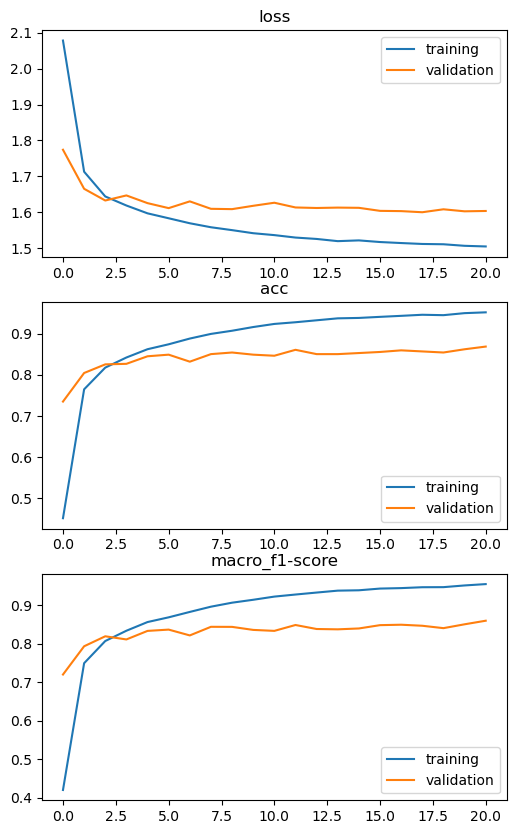

In [26]:
fig, axs = plt.subplots(3, figsize= (6,10))
# loss
axs[0].plot(history_train['loss'], label = 'training')
axs[0].plot(history_val['loss'], label = 'validation')
axs[0].set_title("loss")
axs[0].legend()
# acc
axs[1].plot(history_train['acc'], label = 'training')
axs[1].plot(history_val['acc'], label = 'validation')
axs[1].set_title("acc")
axs[1].legend()
# f1-score
axs[2].plot(history_train['macro_f1-score'], label = 'training')
axs[2].plot(history_val['macro_f1-score'], label = 'validation')
axs[2].set_title("macro_f1-score")
axs[2].legend()
plt.show()

In [27]:
# torch.save(model.state_dict(), PATH_F1)
model.load_state_dict(torch.load('/kaggle/working/best_model.pth'))

<All keys matched successfully>

In [28]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay


print('testing ...')
y_predict = list()
y_labels = list()
test_loss = 0.0
n = 0
with torch.no_grad():
    for data in tqdm(testloader):
        model.eval()
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        y_labels += list(labels.cpu().numpy())
        y_predict += list(outputs.argmax(dim=1).cpu().numpy())
        n+=1

    # print statistics
    test_loss /= n
    print(f"testing loss: {test_loss:.4}" )
    
    report = classification_report(y_labels, y_predict, digits = 4)
    M = confusion_matrix(y_labels, y_predict)
    print(report)
    disp = ConfusionMatrixDisplay(confusion_matrix=M)

testing ...


100%|██████████| 24/24 [00:39<00:00,  1.65s/it]

testing loss: 1.591
              precision    recall  f1-score   support

           0     0.9459    0.8140    0.8750        43
           1     0.9579    0.9681    0.9630        94
           2     0.8759    0.8955    0.8856       134
           3     0.8504    0.9391    0.8926       115
           4     0.9027    0.7727    0.8327       132
           5     0.8837    0.8444    0.8636        45
           6     0.7917    0.9048    0.8444        42
           7     0.8400    0.8514    0.8456        74
           8     0.8250    0.8684    0.8462        38
           9     0.8333    0.8696    0.8511        46

    accuracy                         0.8755       763
   macro avg     0.8707    0.8728    0.8700       763
weighted avg     0.8780    0.8755    0.8749       763



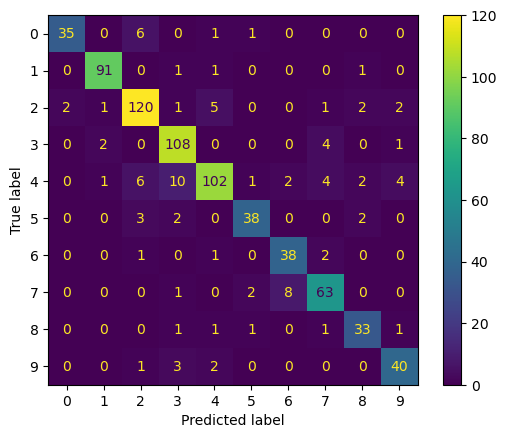

In [29]:
disp.plot()
plt.show()

# All train

In [100]:
#pretrain_weight = torchvision.models.EfficientNet_V2_S_Weights.IMAGENET1K_V1
#net = torchvision.models.efficientnet_v2_s(weights = pretrain_weight)
#net.classifier[1] = nn.Linear(1280, 102)
#net = net.to(device)
#mobile_net 
num_classes = 10
model_ft = torchvision.models.efficientnet_b3(weights=True)
# model_ft = torchvision.models.resnet50(pretrained=True).to(device)
# model_ft = torchvision.models.vgg16(pretrained=True).to(device)

    
model_ft.classifier[-1] = nn.Sequential(
#     nn.Linear(in_features=model_ft.classifier[-1].in_features, out_features=model_ft.classifier[-1].in_features),
#     nn.LSTM(model_ft.classifier[-1].in_features, model_ft.classifier[-1].in_features, bidirectional = False, num_layers=1, batch_first=True),
    nn.Linear(in_features=model_ft.classifier[-1].in_features, out_features=num_classes),
    nn.Softmax(dim=1)
        )

model = model_ft.to(device)

In [101]:
# all augmented dataV4 except verticalflip,colorjitter, seed = 2022
# BATCH_SIZE = 32
NUM_EPOCHS = 23
criterion = nn.CrossEntropyLoss(weight=class_weights)
# criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
# scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda epoch: epoch / NUM_EPOCHS)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)

# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5)

In [102]:
from sklearn.metrics import classification_report
from tqdm import tqdm



all_history_train = {'loss':np.zeros(NUM_EPOCHS), 'acc':np.zeros(NUM_EPOCHS), 'macro_f1-score':np.zeros(NUM_EPOCHS)}
min_val_loss = 1e10
best_f1 = -1
PATH = './best_model.pth'
PATH_F1 = './best_model_f1.pth'

for epoch in range(NUM_EPOCHS):  
    
    print(f'epoch {epoch + 1} \nTraining ...')
    model.train()
    y_predict = list()
    y_labels = list()
    training_loss = 0.0
    n = 0
    with torch.set_grad_enabled(True):
        for inputs, labels in tqdm(allloader):
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            training_loss += loss.item()
            n+=1

            y_labels += list(labels.cpu().numpy())
            y_predict += list(outputs.argmax(dim=1).cpu().numpy())
    scheduler.step()

    report = classification_report(y_labels, y_predict, digits = 4, output_dict = True)
    acc = report["accuracy"]
    f1 = report["macro avg"]["f1-score"]
    support = report["macro avg"]["support"]
    training_loss /= n
    print(f"training loss: {training_loss:.4}, acc: {acc*100:.4}%,  Macro f1-score: {f1*100:.4}%, support: {support}" )
    all_history_train['loss'][epoch] = training_loss
    all_history_train['acc'][epoch] = acc
    all_history_train['macro_f1-score'][epoch] = f1

    if training_loss < min_val_loss:
        torch.save(model.state_dict(), './best_model_train_all.pth')
        min_val_loss = training_loss
    
print('Finished Training')

epoch 1 
Training ...


100%|██████████| 228/228 [07:13<00:00,  1.90s/it]


training loss: 2.037, acc: 49.29%,  Macro f1-score: 44.64%, support: 7275
epoch 2 
Training ...


100%|██████████| 228/228 [06:01<00:00,  1.59s/it]


training loss: 1.683, acc: 78.5%,  Macro f1-score: 77.4%, support: 7275
epoch 3 
Training ...


100%|██████████| 228/228 [05:55<00:00,  1.56s/it]


training loss: 1.623, acc: 83.97%,  Macro f1-score: 83.08%, support: 7275
epoch 4 
Training ...


100%|██████████| 228/228 [05:56<00:00,  1.56s/it]


training loss: 1.602, acc: 85.73%,  Macro f1-score: 85.23%, support: 7275
epoch 5 
Training ...


100%|██████████| 228/228 [05:55<00:00,  1.56s/it]


training loss: 1.586, acc: 87.24%,  Macro f1-score: 86.94%, support: 7275
epoch 6 
Training ...


100%|██████████| 228/228 [06:00<00:00,  1.58s/it]


training loss: 1.57, acc: 88.44%,  Macro f1-score: 88.09%, support: 7275
epoch 7 
Training ...


100%|██████████| 228/228 [06:04<00:00,  1.60s/it]


training loss: 1.561, acc: 89.24%,  Macro f1-score: 89.09%, support: 7275
epoch 8 
Training ...


100%|██████████| 228/228 [06:02<00:00,  1.59s/it]


training loss: 1.545, acc: 90.8%,  Macro f1-score: 90.91%, support: 7275
epoch 9 
Training ...


100%|██████████| 228/228 [06:03<00:00,  1.59s/it]


training loss: 1.537, acc: 92.04%,  Macro f1-score: 92.22%, support: 7275
epoch 10 
Training ...


100%|██████████| 228/228 [06:05<00:00,  1.60s/it]


training loss: 1.535, acc: 92.0%,  Macro f1-score: 92.12%, support: 7275
epoch 11 
Training ...


100%|██████████| 228/228 [06:00<00:00,  1.58s/it]


training loss: 1.528, acc: 92.82%,  Macro f1-score: 93.09%, support: 7275
epoch 12 
Training ...


100%|██████████| 228/228 [06:00<00:00,  1.58s/it]


training loss: 1.525, acc: 93.03%,  Macro f1-score: 93.15%, support: 7275
epoch 13 
Training ...


100%|██████████| 228/228 [05:57<00:00,  1.57s/it]


training loss: 1.522, acc: 93.64%,  Macro f1-score: 93.74%, support: 7275
epoch 14 
Training ...


100%|██████████| 228/228 [05:58<00:00,  1.57s/it]


training loss: 1.519, acc: 93.64%,  Macro f1-score: 93.81%, support: 7275
epoch 15 
Training ...


100%|██████████| 228/228 [06:01<00:00,  1.58s/it]


training loss: 1.516, acc: 94.02%,  Macro f1-score: 94.19%, support: 7275
epoch 16 
Training ...


100%|██████████| 228/228 [05:57<00:00,  1.57s/it]


training loss: 1.512, acc: 94.34%,  Macro f1-score: 94.56%, support: 7275
epoch 17 
Training ...


100%|██████████| 228/228 [05:56<00:00,  1.56s/it]


training loss: 1.509, acc: 94.71%,  Macro f1-score: 94.92%, support: 7275
epoch 18 
Training ...


100%|██████████| 228/228 [06:01<00:00,  1.59s/it]


training loss: 1.508, acc: 94.75%,  Macro f1-score: 95.05%, support: 7275
epoch 19 
Training ...


100%|██████████| 228/228 [06:05<00:00,  1.60s/it]


training loss: 1.508, acc: 94.93%,  Macro f1-score: 95.13%, support: 7275
epoch 20 
Training ...


100%|██████████| 228/228 [06:02<00:00,  1.59s/it]


training loss: 1.51, acc: 94.83%,  Macro f1-score: 95.06%, support: 7275
epoch 21 
Training ...


100%|██████████| 228/228 [06:00<00:00,  1.58s/it]


training loss: 1.507, acc: 94.91%,  Macro f1-score: 95.16%, support: 7275
epoch 22 
Training ...


100%|██████████| 228/228 [05:57<00:00,  1.57s/it]


training loss: 1.505, acc: 95.09%,  Macro f1-score: 95.29%, support: 7275
epoch 23 
Training ...


100%|██████████| 228/228 [05:59<00:00,  1.58s/it]

training loss: 1.504, acc: 95.34%,  Macro f1-score: 95.5%, support: 7275
Finished Training


In [137]:
# torch.save(model.state_dict(), PATH_F1)
model.load_state_dict(torch.load('/kaggle/working/best_model_train_all.pth'))

<All keys matched successfully>

In [ ]:
5555

# Submit

In [138]:
import os
import pandas as pd
import argparse

path = '/kaggle/input/submittest/test'
def gen_filename():
    d={}
    images = os.listdir(path)
    sorted_filenames = sorted(images, key=lambda x: int(x.split("test")[1].split(".")[0]))
    for image in sorted_filenames:
        if image == '.DS_Store': continue
        d[image] = 0

    file = pd.DataFrame(d.keys(), columns=['ID'])
    file.to_csv('submission.csv', index=False)


gen_filename()


In [139]:
submit = pd.read_csv('/kaggle/working/submission.csv')
submit


,ID
0,test0.jpg
1,test1.jpg
2,test2.jpg
3,test3.jpg
4,test4.jpg
...,...
4643,test4643.jpg
4644,test4644.jpg
4645,test4645.jpg
4646,test4646.jpg


In [140]:
test_path = '/kaggle/input/submittest/test'
class TestDataset(Dataset):
    
    def __init__(self, 
                 img_dir, 
                 transforms=None):
        
        super().__init__()
        self.input_dataset = list()

        _, _, files = next(os.walk(os.path.join(img_dir)))
        for image_name in submit['ID']:
#             print(image_name)
            input = [os.path.join(img_dir,image_name), image_name] 
            self.input_dataset.append(input)
        
        self.transforms = transforms

    def __len__(self):
        return len(self.input_dataset)

    def __getitem__(self, idx): 
        img = Image.open(self.input_dataset[idx][0]).convert('RGB')
        x = self.transforms(img)
        return x, self.input_dataset[idx][1]

submitset = TestDataset(test_path,transform)
submitloader = torch.utils.data.DataLoader(submitset, batch_size=32, shuffle=False)

In [141]:
print('running ...')
y_predict = list()
model.eval()
with torch.no_grad():
    for inputs, _ in tqdm(submitloader):

        inputs = inputs.to(device)
        outputs = model(inputs)
        y_predict += list(outputs.argmax(dim=1).cpu().numpy())
print('Finished')


running ...


100%|██████████| 146/146 [03:33<00:00,  1.46s/it]

Finished


In [142]:
len(y_predict)

4648

In [143]:
submit_df = pd.DataFrame()
submit_df['ID'] = list(range(len(y_predict)))
submit_df['class'] = y_predict
submit_df

,ID,class
0,0,4
1,1,4
2,2,1
3,3,4
4,4,1
...,...,...
4643,4643,9
4644,4644,7
4645,4645,5
4646,4646,7


In [145]:
submit_df.to_csv('submission86.csv', index=False)
